In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gpd
import earthpy as et

data = et.data.get_data('spatial-vector-lidar')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [2]:
data_path = os.path.join("data/spatial-vector-lidar")

country_bound_us = gpd.read_file(os.path.join(data_path, "usa", 
                                              "usa-boundary-dissolved.shp"))
                                 
state_bound_us = gpd.read_file(os.path.join(data_path, "usa", 
                                            "usa-states-census-2014.shp"))
                               
pop_places = gpd.read_file(os.path.join(data_path, "global", 
                                        "ne_110m_populated_places_simple", 
                                        "ne_110m_populated_places_simple.shp"))
                                        
ne_roads = gpd.read_file(os.path.join(data_path, "global", 
                                      "ne_10m_roads", "ne_10m_roads.shp"))

In [3]:
country_bound_us_simp = country_bound_us.simplify(.2, preserve_topology=True)

roads_cl = gpd.clip(ne_roads, country_bound_us_simp)
roads_cl.crs = ne_roads.crs

regions_agg = state_bound_us.dissolve(by="region")

In [5]:
roads_region = gpd.sjoin(roads_cl, 
                         regions_agg, 
                         how="inner", 
                         op='intersects')

roads_region[["featurecla", "index_right", "ALAND"]].head()

/home/codespace/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,featurecla,index_right,ALAND
2726,Road,Southeast,138903200855
2725,Road,Southeast,138903200855
4144,Road,Southeast,138903200855
49423,Road,Southeast,138903200855
2709,Road,Southeast,138903200855


In [6]:
country_albers = country_bound_us.to_crs({'init': 'epsg:5070'})
roads_albers = roads_region.to_crs({'init': 'epsg:5070'})

/home/codespace/.python/current/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


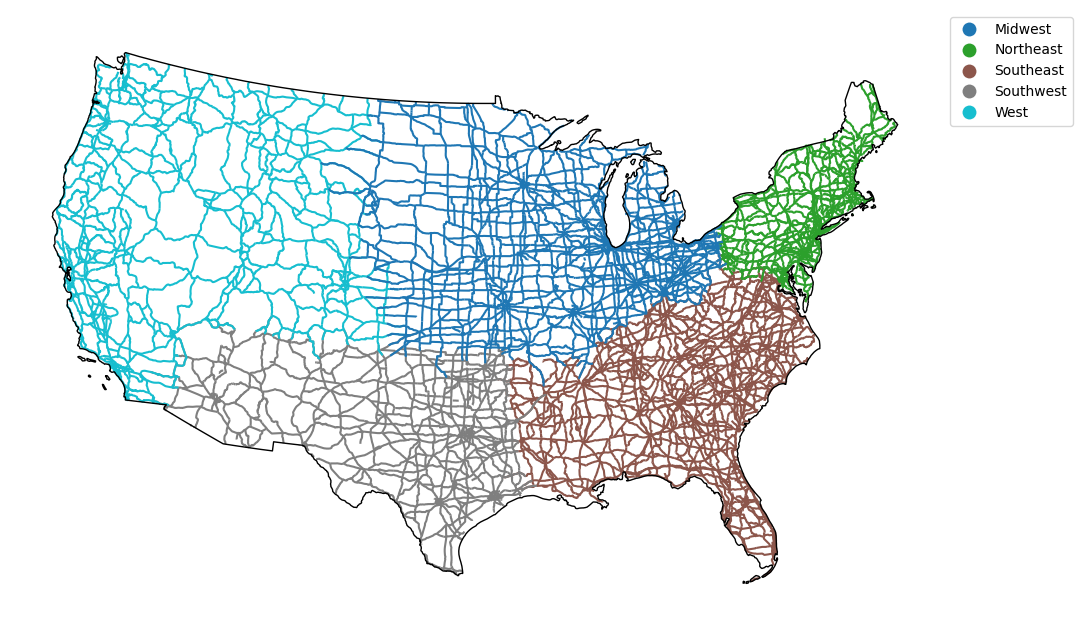

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

country_albers.plot(alpha=1,
                    facecolor="none",
                    edgecolor="black",
                    zorder=10,
                    ax=ax)

roads_albers.plot(column='index_right',
                  ax=ax,
                  legend=True)

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,1))

ax.set_axis_off()
plt.axis('equal')
plt.show()

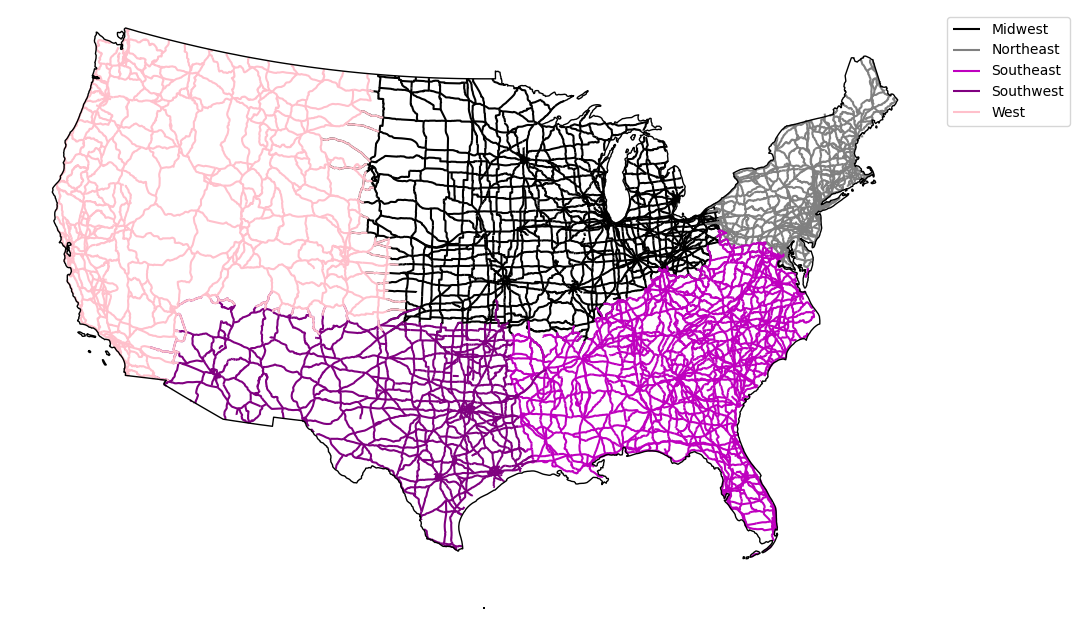

In [9]:
road_attrs = {'Midwest': ['black'],
              'Northeast': ['grey'],
              'Southeast': ['m'],
              'Southwest': ['purple'],
              'West': ['pink']}

fig, ax = plt.subplots(figsize=(12, 8))

regions_agg.plot(edgecolor="black",
                 ax=ax)
country_albers.plot(alpha=1,
                    facecolor="none",
                    edgecolor="black",
                    zorder=10,
                    ax=ax)

for ctype, data in roads_albers.groupby('index_right'):
    data.plot(color=road_attrs[ctype][0],
              label=ctype,
              ax=ax)
    
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
ax.set_axis_off()
plt.axis('equal')
plt.show()

In [10]:
pd.options.display.float_format = '{:.4f}'.format

road_albers_length = roads_albers[['index_right', 'length_km']]

roads_albers.groupby('index_right').sum()

roads_albers['rdlength'] = roads_albers.length
sub = roads_albers[['rdlength', 'index_right']].groupby('index_right').sum()
sub

/tmp/ipykernel_15097/2567198809.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roads_albers.groupby('index_right').sum()


,rdlength
index_right,
Midwest,86575020.6373
Northeast,33786036.8608
Southeast,84343077.8904
Southwest,49373104.8209
West,61379830.5534
